In [1]:
from api import api
from sqlalchemy.orm import Query
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Utility function to show a set of images 

In [2]:
def show_images(file_list):
    fig=plt.figure(figsize=(16, 6))
    columns = 5
    rows = 2
    for i in range(1, columns*rows+1):
        img = mpimg.imread(file_list[i-1])
        fig.add_subplot(rows, columns, i)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

## Test image queries

Query for images for styles 2011 and pick any 10 of them

In [3]:
api.process_query(Query(api.StyleImage).filter(api.StyleImage.year == 2011).limit(10), 'year2011')

Check folder content

In [4]:
result = api.list_folder('year2011')

In [5]:
result['images']

['out/year2011/images/12369.jpg',
 'out/year2011/images/12840.jpg',
 'out/year2011/images/12967.jpg',
 'out/year2011/images/13089.jpg',
 'out/year2011/images/13368.jpg',
 'out/year2011/images/13992.jpg',
 'out/year2011/images/14985.jpg',
 'out/year2011/images/15259.jpg',
 'out/year2011/images/15970.jpg',
 'out/year2011/images/1855.jpg',
 'out/year2011/images/18653.jpg',
 'out/year2011/images/18780.jpg',
 'out/year2011/images/19494.jpg',
 'out/year2011/images/21379.jpg',
 'out/year2011/images/6159.jpg',
 'out/year2011/images/6842.jpg',
 'out/year2011/images/6965.jpg',
 'out/year2011/images/9036.jpg',
 'out/year2011/images/9111.jpg',
 'out/year2011/images/9204.jpg']

In [6]:
result['styles']

['out/year2011/styles/12369.json',
 'out/year2011/styles/12840.json',
 'out/year2011/styles/12967.json',
 'out/year2011/styles/13089.json',
 'out/year2011/styles/13368.json',
 'out/year2011/styles/13992.json',
 'out/year2011/styles/14985.json',
 'out/year2011/styles/15259.json',
 'out/year2011/styles/15970.json',
 'out/year2011/styles/1855.json',
 'out/year2011/styles/18653.json',
 'out/year2011/styles/18780.json',
 'out/year2011/styles/19494.json',
 'out/year2011/styles/21379.json',
 'out/year2011/styles/6159.json',
 'out/year2011/styles/6842.json',
 'out/year2011/styles/6965.json',
 'out/year2011/styles/9036.json',
 'out/year2011/styles/9111.json',
 'out/year2011/styles/9204.json']

Show retrieved images

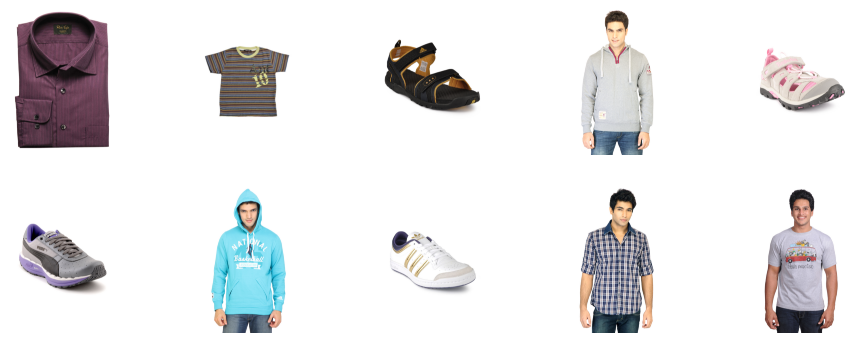

In [7]:
show_images(result['images'])

Apply transformation to images

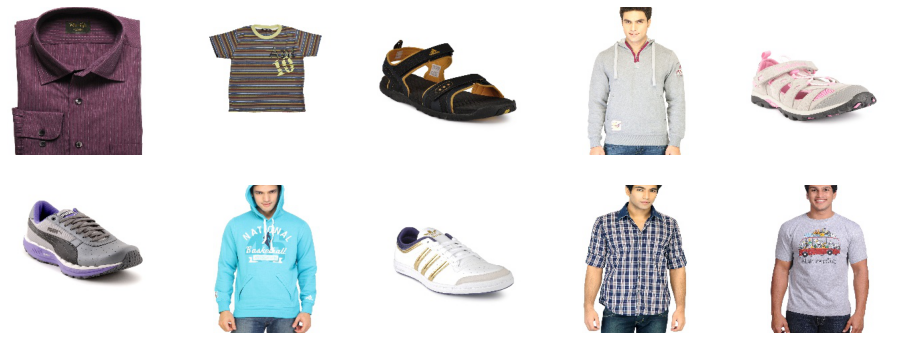

In [8]:
api.transform_folder('year2011', 224)
show_images(api.list_folder('year2011')['augmented_images'])

Make query for women styles to prove that it works

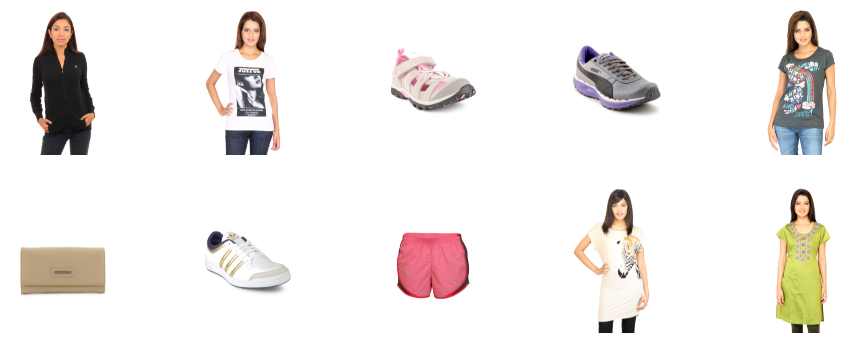

In [9]:
api.process_query(Query(api.StyleImage).filter(api.StyleImage.year == 2011)\
                  .filter(api.StyleImage.gender == 'Women').limit(10), 'women-year2011')
show_images(api.list_folder('women-year2011')['images'])

## Model verification

In [10]:
import torch
import torchvision
from torchvision import transforms as transforms

In [11]:
# ssl fix for ubuntu to download pre-trained model
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Init model

In [12]:
model_ft = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_ft.to(0)
model_ft.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

Reading single image

In [13]:
img = mpimg.imread(api.list_folder('year2011')['images'][3])

In [14]:
img_t = transforms.ToTensor()(img).to(0)
batch_t = torch.unsqueeze(img_t, 0)

/home/andrei/.pyenv/versions/3.7.0/envs/imachines2/lib/python3.7/site-packages/torchvision/transforms/functional.py:56: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1)))


Predicting result and transfer data from GPU to CPU

In [15]:
import gc
prediction = {'boxes':[],'labels':[]}
with torch.no_grad():
    temp = model_ft(batch_t)
    prediction = {'boxes':temp[0]['boxes'].to('cpu'),'labels':temp[0]['labels'].to('cpu')}
    del temp
    torch.cuda.empty_cache()
    gc.collect()


/home/andrei/.pyenv/versions/3.7.0/envs/imachines2/lib/python3.7/site-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


In [16]:
prediction

{'boxes': tensor([[ 322.4798,   79.0457, 1489.8153, 2368.6311],
         [ 455.5645, 2165.6187,  491.3945, 2245.5203],
         [1188.0458,  607.4791, 1476.1871, 2324.7439],
         [ 455.6644, 2166.7778,  491.0452, 2247.9868],
         [ 885.6450,  528.8255, 1466.2683, 2342.3054]]),
 'labels': tensor([ 1, 75,  1, 77,  1])}

In [17]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

Testing 

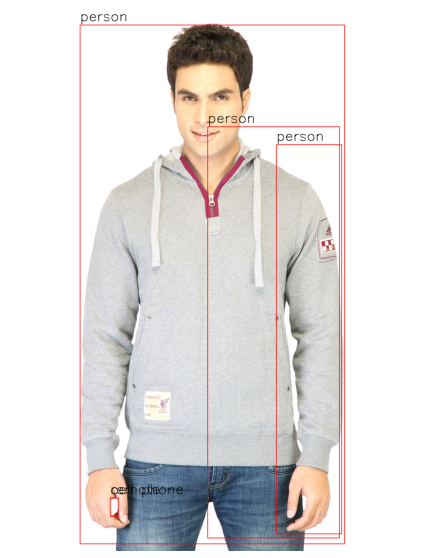

In [18]:
import cv2

for i in range(len(prediction['boxes'])):
    x1, x2, x3, x4 = map(int, prediction['boxes'][i].tolist())
    cl = prediction['labels'][i]
    
    (test_width, text_height), baseline = cv2.getTextSize(COCO_INSTANCE_CATEGORY_NAMES[cl],
                                                              cv2.FONT_HERSHEY_SIMPLEX,
                                                              2, 1)
    cv2.rectangle(img, (x1, x2), (x3, x4), (255, 0, 0), 2)
    cv2.putText(img, COCO_INSTANCE_CATEGORY_NAMES[cl], (x1, x2 - baseline), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 2) 
    
plt.figure(figsize=(8,10))
plt.axis('off')
plt.imshow(img)

## Run model for the whole folder

In [19]:
api.predict_folder('year2011')

Time elapsed: 1.0127370357513428


[{'boxes': tensor([[ 22.6077,   9.1938, 188.4213, 166.9448],
          [ 40.4667,  11.5529, 174.9068, 108.0492],
          [  1.5974,   7.6797, 188.1521, 212.2741],
          [ 16.6789,   9.8223, 186.8154, 211.6983],
          [ 19.1209,   0.0000, 188.1901, 222.0852],
          [ 38.0549,   7.3256, 185.4675, 114.3715],
          [ 26.0969,  17.1198, 181.3891, 173.7316],
          [  5.8019,   0.9731, 196.9271, 215.7561]], grad_fn=<CopyBackwards>),
  'labels': tensor([31, 32, 33, 32, 28, 28, 87, 62])},
 {'boxes': tensor([[  5.6727,  14.5446, 216.8145, 215.9490],
          [ 12.8133,  25.8992, 201.7675, 204.2307],
          [ 56.3810, 110.6521, 170.2633, 142.9005],
          [ 55.1688, 118.2437, 167.6457, 132.1570],
          [ 54.8186, 117.4432, 171.1496, 132.7294],
          [ 16.2250,   7.1221, 202.1686, 213.4782],
          [ 58.5030, 116.5718, 170.0116, 123.0249],
          [  0.0000,  25.7915, 224.0000, 219.5211]], grad_fn=<CopyBackwards>),
  'labels': tensor([65, 15, 84, 84, 15, 8